In [1]:
from pyspark.sql import SparkSession
import xG_preprocessing as pp
from xG_training import ModelTrainer
from xG_evaluation import ModelEvaluation
import time

In [3]:
spark = SparkSession.builder.appName("xG6").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 2000)

### Preprocessing

In [4]:
events = spark.read.csv('Data/events.csv',header=True,inferSchema=True,sep=';')

In [5]:
start_time = time.time()
shots = pp.preprocessing(events, spark)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Dataset preparation took: {elapsed_time:.2f} seconds.")

Data loaded
Spatial data calculated
Preferred foot calculated
Goal column created


Number of players inside the area calculated
Dummies created
Boolean data converted to integer
Dataset preparation took: 31.60 seconds.


In [6]:
# Save ready shots data for faster loading next time
start_time = time.time()
shots.write.option("header", "true").csv('Data/Datas/shots.csv')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Saving preprocessed data took {elapsed_time:.2f} seconds.")

25/01/28 14:09:49 WARN TaskSetManager: Stage 5 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.


Saving preprocessed data took 35.65 seconds.


In [7]:
# Reading the data
shots = spark.read.csv('Data/Datas/shots.csv',header=True,inferSchema=True)

In [9]:
shots.show()

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_open_goal|shot_follows_dribble|players_inside_area|shot_statsbomb_xg|shot_outcome|goal|sb_pred

## Model Training

In [10]:
# splitting data
train_data, test_data = pp.pre_training(shots,train_size=0.7)

## Regression Logistique

### Training

In [9]:
start_time = time.time()
log_reg = ModelTrainer(train_data,test_data,model_type='logistic',max_iter=100)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

25/01/28 13:37:26 WARN TaskSetManager: Stage 41 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:37:55 WARN TaskSetManager: Stage 56 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:38:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/28 13:38:29 WARN TaskSetManager: Stage 251 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:38:59 WARN TaskSetManager: Stage 266 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:39:31 WARN TaskSetManager: Stage 281 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.


Training took 154.55 seconds.


In [ ]:
log_reg = ModelTrainer(train_data,test_data,model_type='logistic',max_iter=100)
print(f"Training took {elapsed_time:.2f} seconds.")

25/01/28 14:10:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Training took 5.79 seconds.


ROC-AUC for max_iter=10: 80.31%
ROC-AUC for max_iter=20: 80.41%
ROC-AUC for max_iter=30: 80.41%
ROC-AUC for max_iter=40: 80.41%
ROC-AUC for max_iter=50: 80.41%
ROC-AUC for max_iter=60: 80.41%
ROC-AUC for max_iter=70: 80.41%
ROC-AUC for max_iter=80: 80.41%
ROC-AUC for max_iter=90: 80.41%
ROC-AUC for max_iter=100: 80.41%


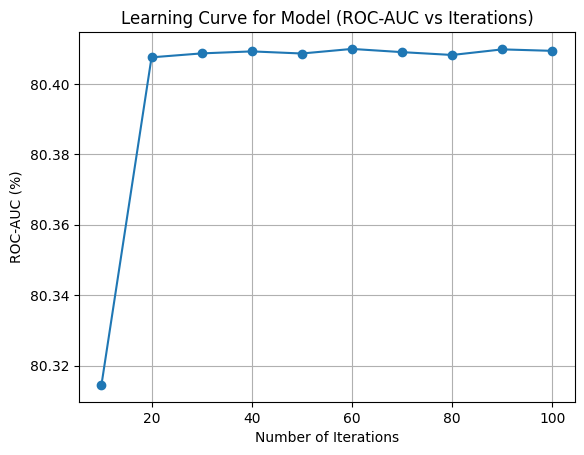

In [7]:
log_reg.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

### Evaluation

In [12]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [14]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.14,
 'Precision': 69.73,
 'Recall': 20.42,
 'Sensitivity': 20.42,
 'Specificity': 98.89,
 'F1': 31.59,
 'FPR': 1.11,
 'FNR': 79.58}

In [16]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.69,
 'Precision': 85.12,
 'Recall': 77.12,
 'Sensitivity': 77.12,
 'Specificity': 99.5,
 'F1': 80.92,
 'FPR': 0.5,
 'FNR': 22.88}

In [17]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00371, 'RMSE': 0.06089, 'MAE': 0.0344, 'R2': 83.13}

In [18]:
# Feature importance
fi = log_reg.feature_importance()
fi.sort_values(by='Importance',ascending=False)

,Feature,Importance
9,corner_type,2.435549
11,pk_type,2.033136
10,fk_type,1.834886
14,lob_technique,0.940252
25,shot_open_goal,0.897951
17,diving_h_technique,0.668666
4,from_counter,0.401767
20,preferred_foot_shot,0.301096
24,shot_one_on_one,0.256291
6,from_keeper,0.216667


### Confirming that the model is not Overfitting

Training took 2.18 seconds.
ROC-AUC for max_iter=10: 81.70%
ROC-AUC for max_iter=20: 81.73%
ROC-AUC for max_iter=30: 81.73%
ROC-AUC for max_iter=40: 81.73%
ROC-AUC for max_iter=50: 81.73%
ROC-AUC for max_iter=60: 81.73%
ROC-AUC for max_iter=70: 81.73%
ROC-AUC for max_iter=80: 81.73%
ROC-AUC for max_iter=90: 81.73%
ROC-AUC for max_iter=100: 81.73%


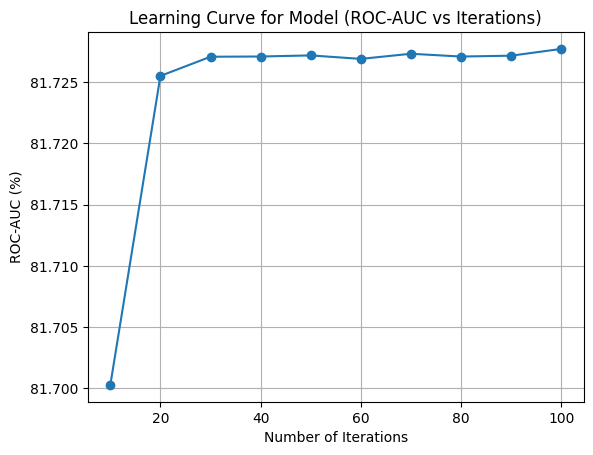

In [17]:
start_time = time.time()
log_reg = ModelTrainer('logistic',train_data,train_data,max_iter=100)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")
log_reg.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [18]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [20]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [21]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [22]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

## Naive Bayes

In [22]:
start_time = time.time()
nb = ModelTrainer(train_data,test_data,model_type='nb')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 99.5 seconds.


ROC-AUC for max_iter=10: 67.53%
ROC-AUC for max_iter=20: 67.53%
ROC-AUC for max_iter=30: 67.53%
ROC-AUC for max_iter=40: 67.53%
ROC-AUC for max_iter=50: 67.53%
ROC-AUC for max_iter=60: 67.53%
ROC-AUC for max_iter=70: 67.53%
ROC-AUC for max_iter=80: 67.53%
ROC-AUC for max_iter=90: 67.53%
ROC-AUC for max_iter=100: 67.53%


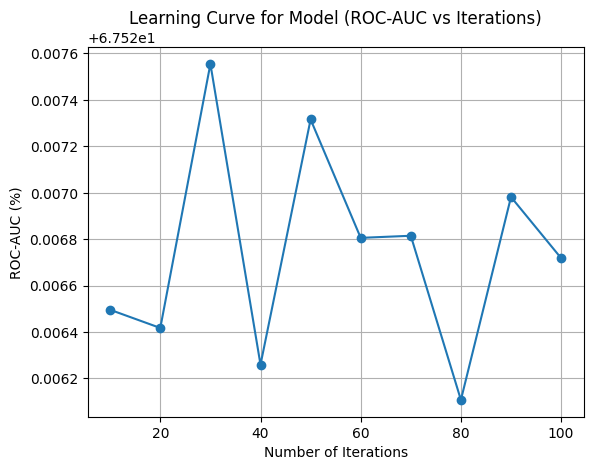

In [20]:
nb.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [59]:
predictions = nb.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 76.51,
 'Precision': 25.58,
 'Recall': 57.98,
 'Sensitivity': 57.98,
 'Specificity': 78.84,
 'F1': 35.5,
 'FPR': 21.16,
 'FNR': 42.02}

In [60]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 78.15,
 'Precision': 13.89,
 'Recall': 97.42,
 'Sensitivity': 97.42,
 'Specificity': 77.43,
 'F1': 24.31,
 'FPR': 22.57,
 'FNR': 2.58}

In [61]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.14119, 'RMSE': 0.37575, 'MAE': 0.2193, 'R2': -542.53}

### Confirming that the model is not Overfitting

In [ ]:
start_time = time.time()
nb = ModelTrainer(train_data,train_data,model_type='nb',max_iter=100)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

ROC-AUC for max_iter=10: 66.78%
ROC-AUC for max_iter=20: 66.78%
ROC-AUC for max_iter=30: 66.78%
ROC-AUC for max_iter=40: 66.78%
ROC-AUC for max_iter=50: 66.78%
ROC-AUC for max_iter=60: 66.78%
ROC-AUC for max_iter=70: 66.78%
ROC-AUC for max_iter=80: 66.78%
ROC-AUC for max_iter=90: 66.78%
ROC-AUC for max_iter=100: 66.78%


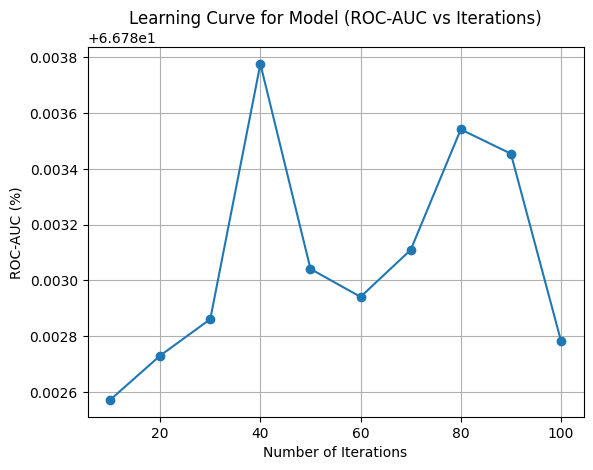

In [66]:
nb.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [63]:
predictions = nb.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 76.55,
 'Precision': 24.61,
 'Recall': 58.28,
 'Sensitivity': 58.28,
 'Specificity': 78.73,
 'F1': 34.61,
 'FPR': 21.27,
 'FNR': 41.72}

In [64]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 78.25,
 'Precision': 14.16,
 'Recall': 97.11,
 'Sensitivity': 97.11,
 'Specificity': 77.53,
 'F1': 24.71,
 'FPR': 22.47,
 'FNR': 2.89}

In [65]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.13969, 'RMSE': 0.37375, 'MAE': 0.21764, 'R2': -522.02}

## Decision Tree

In [7]:
start_time = time.time()
dt = ModelTrainer(train_data,test_data,model_type='dt')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

25/01/28 13:59:12 WARN TaskSetManager: Stage 76 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 13:59:42 WARN TaskSetManager: Stage 91 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 14:00:12 WARN TaskSetManager: Stage 113 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/28 14:00:44 WARN TaskSetManager: Stage 158 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.


Training took 121.30 seconds.


ROC-AUC for max_iter=10: 57.67%
ROC-AUC for max_iter=20: 57.67%
ROC-AUC for max_iter=30: 57.67%
ROC-AUC for max_iter=40: 57.67%
ROC-AUC for max_iter=50: 57.67%
ROC-AUC for max_iter=60: 57.67%
ROC-AUC for max_iter=70: 57.67%
ROC-AUC for max_iter=80: 57.67%
ROC-AUC for max_iter=90: 57.67%
ROC-AUC for max_iter=100: 57.67%


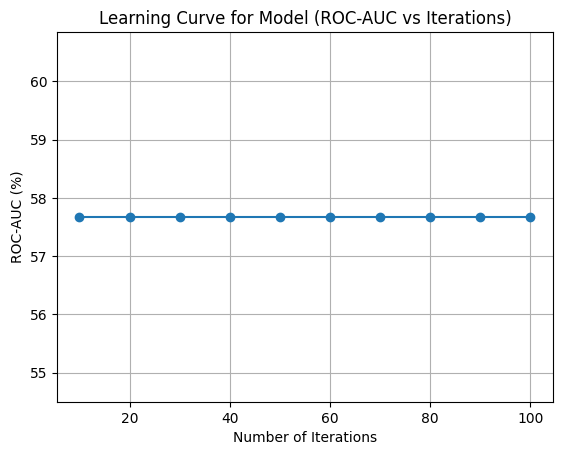

In [27]:
dt.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [29]:
predictions = dt.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [30]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 89.96,
 'Precision': 71.67,
 'Recall': 16.36,
 'Sensitivity': 16.36,
 'Specificity': 99.19,
 'F1': 26.63,
 'FPR': 0.81,
 'FNR': 83.64}

In [33]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.06,
 'Precision': 82.62,
 'Recall': 58.33,
 'Sensitivity': 58.33,
 'Specificity': 99.54,
 'F1': 68.38,
 'FPR': 0.46,
 'FNR': 41.67}

In [34]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00727, 'RMSE': 0.08526, 'MAE': 0.0484, 'R2': 66.92}

In [35]:
fi_dt = dt.feature_importance()
fi_dt.sort_values(by='Importance',ascending=False)

,Feature,Importance
19,shot_angle,0.394019
8,header,0.200981
18,distance_to_goal,0.117130
25,shot_open_goal,0.116713
11,pk_type,0.104172
24,shot_one_on_one,0.046879
22,shot_aerial_won,0.011056
3,from_corner,0.006698
27,players_inside_area,0.002352
1,from_fk,0.000000


### Confirming that the model is not Overfitting

Training took 1.84 seconds.
ROC-AUC for max_iter=10: 81.70%
ROC-AUC for max_iter=20: 81.73%
ROC-AUC for max_iter=30: 81.73%
ROC-AUC for max_iter=40: 81.73%
ROC-AUC for max_iter=50: 81.73%
ROC-AUC for max_iter=60: 81.73%
ROC-AUC for max_iter=70: 81.73%
ROC-AUC for max_iter=80: 81.73%
ROC-AUC for max_iter=90: 81.73%
ROC-AUC for max_iter=100: 81.73%


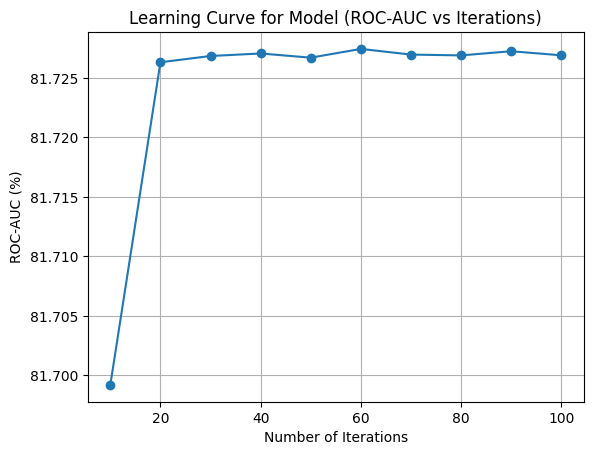

In [36]:
start_time = time.time()
dt = ModelTrainer(train_data,train_data,model_type='dt',max_iter=60)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")
dt.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [38]:
predictions = dt.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [40]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [41]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

## SVM

In [41]:
start_time = time.time()
svm = ModelTrainer(train_data,test_data,model_type='svm')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 177.2 seconds.


ROC-AUC for max_iter=10: 76.19%
ROC-AUC for max_iter=20: 79.18%
ROC-AUC for max_iter=30: 76.67%
ROC-AUC for max_iter=40: 65.27%
ROC-AUC for max_iter=50: 67.49%
ROC-AUC for max_iter=60: 72.58%
ROC-AUC for max_iter=70: 74.31%
ROC-AUC for max_iter=80: 71.23%
ROC-AUC for max_iter=90: 67.38%
ROC-AUC for max_iter=100: 73.79%


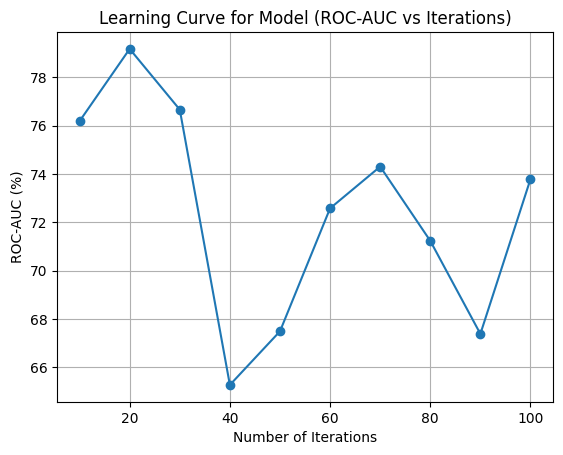

In [37]:
svm.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [48]:
predictions = svm.predictions
predictions = predictions.withColumnRenamed('rawPrediction','probability')
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [49]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.07,
 'Precision': 73.98,
 'Recall': 16.85,
 'Sensitivity': 16.85,
 'Specificity': 99.26,
 'F1': 27.44,
 'FPR': 0.74,
 'FNR': 83.15}

In [50]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.47,
 'Precision': 90.75,
 'Recall': 63.94,
 'Sensitivity': 63.94,
 'Specificity': 99.76,
 'F1': 75.02,
 'FPR': 0.24,
 'FNR': 36.06}

In [51]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 1.16644, 'RMSE': 1.08002, 'MAE': 1.06679, 'R2': -5208.42}

In [52]:
fi_svm = svm.feature_importance()
fi_svm.sort_values(by='Importance',ascending=False)

,Feature,Importance
25,shot_open_goal,2.000000e+00
11,pk_type,1.968162e+00
9,corner_type,2.125180e-06
10,fk_type,9.281154e-07
20,preferred_foot_shot,3.849937e-07
14,lob_technique,2.877973e-07
21,under_pressure,1.510668e-07
8,header,3.423637e-08
23,shot_first_time,3.353126e-08
12,half_volley_technique,0.000000e+00


In [ ]:
start_time = time.time()
svm = ModelTrainer(train_data,train_data,model_type='svm',max_iter=60)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")
svm.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [19]:
spark.stop()

In [69]:
FEATURES = ['from_rp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique',
            'diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']

In [71]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Split data
train, test = shots.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

# Define evaluator for AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction", metricName="areaUnderROC")


In [72]:
lr = LogisticRegression(featuresCol="features", labelCol="goal")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC-ROC: {lr_auc}")

Logistic Regression AUC-ROC: 0.8040863485273682


In [73]:
nb = NaiveBayes(featuresCol="features", labelCol="goal")
nb_model = nb.fit(train)
nb_predictions = nb_model.transform(test)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Naïve Bayes AUC-ROC: {nb_auc}")

Naïve Bayes AUC-ROC: 0.6749610726643598


In [74]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="goal")
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC-ROC: {dt_auc}")

Decision Tree AUC-ROC: 0.5330984524425797


In [75]:
svm = LinearSVC(featuresCol="features", labelCol="goal", maxIter=10)
svm_model = svm.fit(train)
svm_predictions = svm_model.transform(test)
svm_auc = evaluator.evaluate(svm_predictions)
print(f"SVM AUC-ROC: {svm_auc}")

SVM AUC-ROC: 0.748943887420647
